# Barotropic Model #

Here will will use pyqg to reproduce the results of the paper: <br />
J. C. Mcwilliams (1984). The emergence of isolated coherent vortices in turbulent flow. Journal of Fluid Mechanics, 146, pp 21-43 [doi:10.1017/S0022112084001750](http://dx.doi.org/10.1017/S0022112084001750)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pyqg

McWilliams performed freely-evolving 2D turbulence ($R_d = \infty$, $\beta =0$) experiments on a $2\pi\times 2\pi$ periodic box.

In [2]:
# create the model object
m = pyqg.BTModel(L=2.*np.pi, nx=256, 
                 beta=0., H=1., rek=0., rd=None,
                 tmax=40, dt=0.001, taveint=1,
                 ntd=4)
# in this example we used ntd=4, four threads
# if your machine has more (or fewer) cores available, you could try changing it

INFO:  Logger initialized
INFO:  Kernel initialized


## Initial condition
The initial condition is random, with a prescribed spectrum
$$
|\hat{\psi}|^2 = A \,\kappa^{-1}\left[1 + \left(\frac{\kappa}{6}\right)^4\right]^{-1}\,,
$$
where $\kappa$ is the wavenumber magnitude. The constant A is determined so that the initial energy is $KE = 0.5$.

In [3]:
# generate McWilliams 84 IC condition

fk = m.wv != 0
ckappa = np.zeros_like(m.wv2)
ckappa[fk] = np.sqrt( m.wv2[fk]*(1. + (m.wv2[fk]/36.)**2) )**-1

nhx,nhy = m.wv2.shape

Pi_hat = np.random.randn(nhx,nhy)*ckappa +1j*np.random.randn(nhx,nhy)*ckappa

Pi = m.ifft( Pi_hat[np.newaxis,:,:] )
Pi = Pi - Pi.mean()
Pi_hat = m.fft( Pi )
KEaux = m.spec_var( m.wv*Pi_hat )

pih = ( Pi_hat/np.sqrt(KEaux) )
qih = -m.wv2*pih
qi = m.ifft(qih)

In [4]:
# initialize the model with that initial condition
m.set_q(qi)

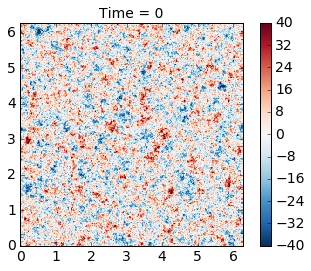

In [ ]:
# define a quick function for plotting and visualize the initial condition
def plot_q(m, qmax=40):
    fig, ax = plt.subplots()
    pc = ax.pcolormesh(m.x,m.y,m.q.squeeze(), cmap='RdBu_r')
    pc.set_clim([-qmax, qmax])
    ax.set_xlim([0, 2*np.pi])
    ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    plt.title('Time = %g' % m.t)
    plt.show()

plot_q(m)

## Runing the model

Here we demonstrate how to use the ``run_with_snapshots`` feature to periodically stop the model and perform some action (in this case, visualization).

In [ ]:
for _ in m.run_with_snapshots(tsnapstart=0, tsnapint=10):
    plot_q(m)

INFO: Step: 1000, Time: 1.00e+00, KE: 4.96e-01, CFL: 0.111
INFO: Step: 2000, Time: 2.00e+00, KE: 4.95e-01, CFL: 0.108
INFO: Step: 3000, Time: 3.00e+00, KE: 4.94e-01, CFL: 0.118
INFO: Step: 4000, Time: 4.00e+00, KE: 4.93e-01, CFL: 0.129


The genius of McWilliams (1984) was that he showed that the initial random vorticity field organizes itself into strong coherent vortices. This is true in significant part of the parameter space. This was previously suspected but unproven, mainly because people did not have computer resources to run the simulation long enough. Thirty years later we can perform such simulations in a couple of minutes on a laptop!

Also, note that the energy is nearly conserved, as it should be, and this is a nice test of the model.

## Plotting spectra

In [ ]:
energy = m.get_diagnostic('KEspec')
enstrophy = m.get_diagnostic('Ensspec')

In [ ]:
# this makes it easy to calculate an isotropic spectrum
from pyqg import diagnostic_tools as tools
kr, energy_iso = tools.calc_ispec(m,energy.squeeze())
_, enstrophy_iso = tools.calc_ispec(m,enstrophy.squeeze())

In [ ]:
ks = np.array([3.,80])
es = 5*ks**-4
plt.loglog(kr,energy_iso)
plt.loglog(ks,es,'k--')
plt.text(2.5,.0001,r'$k^{-4}$',fontsize=20)
plt.ylim(1.e-10,1.e0)
plt.xlabel('wavenumber')
plt.title('Energy Spectrum')

In [ ]:
ks = np.array([3.,80])
es = 5*ks**(-5./3)
plt.loglog(kr,enstrophy_iso)
plt.loglog(ks,es,'k--')
plt.text(5.5,.01,r'$k^{-5/3}$',fontsize=20)
plt.ylim(1.e-3,1.e0)
plt.xlabel('wavenumber')
plt.title('Enstrophy Spectrum')

# Adding topography

pyqg supports bottom topography, which can be easily set by the user. Here we extend the example above to include a Guassian topographic bump.

In [ ]:
mtopo = pyqg.BTModel(L=2.*np.pi, nx=256, 
                 beta=0., H=1., rek=0., rd=None,
                 tmax=40, dt=0.001, taveint=1, f=1.,
                 ntd=4)

In [ ]:
mtopo.set_q(qi)

In [ ]:
# set topography
R2 = 1.
etab = 10*np.exp( -(m.x-np.pi)**2/R2  -(m.y-np.pi)**2/R2  )
etab = etab - etab.mean()
mtopo.set_h(etab)

In [ ]:
# define a quick function
def plot_q(mtopo, qmax=40):
    fig, ax = plt.subplots()
    pc = ax.pcolormesh(mtopo.x,mtopo.y,mtopo.q.squeeze()+mtopo.qtopo, cmap='RdBu_r')
    pc.set_clim([-qmax,qmax])
    ax.set_xlim([0, 2*np.pi])
    ax.set_ylim([0, 2*np.pi]);
    ax.set_aspect(1)
    plt.colorbar(pc)
    plt.title('Time = %g' % mtopo.t)
    plt.show()

plot_q(mtopo)

In [ ]:
for _ in mtopo.run_with_snapshots(tsnapstart=0, tsnapint=10):
    plot_q(mtopo)

In [ ]:
fig, ax = plt.subplots()
pc = plt.contourf(mtopo.x,mtopo.y,np.fft.irfft2(mtopo.ph[0]),np.linspace(-2,2,10),cmap='RdBu_r')
plt.contour(mtopo.x,mtopo.y,etab,colors='k')
ax.set_xlim([0, 2*np.pi])
ax.set_ylim([0, 2*np.pi]);
#pc.set_clim([-40,40])
plt.colorbar(pc)
ax.set_aspect(1)